
    This Source Code Form is subject to the terms of the Mozilla Public
    License, v. 2.0. If a copy of the MPL was not distributed with this
    file, You can obtain one at http://mozilla.org/MPL/2.0/.


In [1]:
# Enable automatic module reload
%load_ext autoreload
%autoreload 2

# To ease the loading of modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

# Allow to parallelize all benchmarks to do
import json
import ray

# Agent - BEACS - BENCHMARKING

## Main parameters

In [6]:
#Environmental Set Up
CLASSIFIER_LENGTH = 2
NUMBER_OF_POSSIBLE_ACTIONS = 3
MOUNTAINCAR = "MountainCar-v0"
POS_BUCKETS = 5
VEL_BUCKETS = 4
MAX_EPISODE_STEPS = 1000

#Exploration Set Up
NUMBER_OF_EXPLORE_TRIALS = 100
METRICS_TRIAL_FREQUENCY_EXPLORE = 1
EPSILON = 0.50
BETA_ALP = 0.05

#Exploitation Set Up
NUMBER_OF_EXPLOIT_TRIALS = 5000

#RL Set Up
GAMMA = 0.99
BETA_RL = 0.1

#BEACS Set Up
ENABLE_EP = True

#CRACS Set up
APPLY_CRACS = True
CRACS_KEEP_UNRELIABLE = False

#Seed
SEED = None

#Parallelization and Iterations for Stats
NUMBER_OF_ITERATIONS_TO_BENCH = 30

JSON_RESULTS_FILENAME = "Beacs_mountaincar.json"

## Launching Ray for Multiprocessing

In [3]:
# Local Mode
runtime_env= {"working_dir": ".."}
ray.init(ignore_reinit_error=True, runtime_env=runtime_env)
# Remote Mode
#runtime_env= {"working_dir": "."}
#ray.init(address='auto', _redis_password='5241590000000000', runtime_env=runtime_env)
#time.sleep(2.0)

2023-07-12 03:39:44,332	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
2023-07-12 03:39:51,119	INFO packaging.py:503 -- Creating a file package for local directory '..'.
2023-07-12 03:39:52,593	INFO packaging.py:330 -- Pushing file package 'gcs://_ray_pkg_44b77cca19563584.zip' (64.86MiB) to Ray cluster...
2023-07-12 03:39:53,708	INFO packaging.py:343 -- Successfully pushed file package 'gcs://_ray_pkg_44b77cca19563584.zip'.


Python version:,3.10.9
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


## Environment - MountainCar

In [ ]:
@ray.remote
def bench_on_mountain_car(env):
    # To ease the loading of modules
    import os
    import sys
    import time

    # Load BEACS module
    from agents.beacs import BEACS, BEACSConfiguration

    # Load particular Environment Adapter
    from my_examples.adapter.MountainCarEnvironmentAdapter import MountainCarEnvironmentAdapter

    # Load Metrics
    from my_examples.metrics.MountainCarMetrics import _mountaincar_metrics, get_score_exploit

    # Load environments
    import gymnasium as gym
    
    cfg_explore = BEACSConfiguration(
        classifier_length=CLASSIFIER_LENGTH,
        number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
        environment_adapter=MountainCarEnvironmentAdapter(POS_BUCKETS, VEL_BUCKETS),
        user_metrics_collector_fcn=_mountaincar_metrics,
        metrics_trial_frequency=METRICS_TRIAL_FREQUENCY_EXPLORE,
        do_ep=ENABLE_EP,
        beta_alp=BETA_ALP,
        beta_rl=BETA_RL,
        gamma=GAMMA,
        epsilon=EPSILON,
        u_max=CLASSIFIER_LENGTH,
        mu=0.,
        chi=0.,
        bs_max=0,
        seed=SEED
    )

    cfg_exploit = BEACSConfiguration(
        classifier_length=CLASSIFIER_LENGTH,
        number_of_possible_actions=NUMBER_OF_POSSIBLE_ACTIONS,
        environment_adapter=MountainCarEnvironmentAdapter(POS_BUCKETS, VEL_BUCKETS),
        user_metrics_collector_fcn=_mountaincar_metrics,
        metrics_trial_frequency=1,
        do_ep=ENABLE_EP,
        beta_alp=BETA_ALP,
        beta_rl=BETA_RL,
        gamma=GAMMA,
        epsilon=0.,
        u_max=CLASSIFIER_LENGTH,
        mu=0.,
        chi=0.,
        bs_max=0,
        seed=SEED
    )

    # Initialize environment
    MountainCar = gym.make(MOUNTAINCAR)
    # To update the maximal number of step in a unique episode 
    MountainCar._max_episode_steps = MAX_EPISODE_STEPS
    # Reset it, by putting an agent into random position
    state, _info = MountainCar.reset(seed=SEED)

    # Training of BEACS - Exploration
    explore_start_time = time.process_time()
    agent_explore = BEACS(cfg_explore)
    population_explore, metrics_explore = agent_explore.explore(MountainCar, NUMBER_OF_EXPLORE_TRIALS)
    explore_end_time = time.process_time()
    
    # Applying CRACS
    cracs_start_time = time.process_time()
    agent_explore.apply_CRACS(keep_unreliable=CRACS_KEEP_UNRELIABLE)
    cracs_end_time = time.process_time()
    population_explore = agent_explore.get_population()
    mountaincar_metrics = _mountaincar_metrics(population_explore, MountainCar)
    
    # Using BEACS - Exploitation - Using RL module
    exploit_start_time = time.process_time()
    agent_exploit = BEACS(cfg_exploit, population_explore)
    population_exploit, metrics_exploit = agent_exploit.exploit(MountainCar, NUMBER_OF_EXPLOIT_TRIALS)
    exploit_end_time = time.process_time()
    
    # Get average 'steps to exit' in all exploitation modes
    avg_step_exploit, avg_step_exploit_last_100, max_average_scores, solved, average_scores = get_score_exploit(metrics_exploit, NUMBER_OF_EXPLOIT_TRIALS)
    
    result = {
        'population' : mountaincar_metrics['population'],
        'numerosity' : mountaincar_metrics['numerosity'],
        'reliable' : mountaincar_metrics['reliable'],
        
        'avg_step_exploit' : avg_step_exploit,
        'avg_step_exploit_last_100' : avg_step_exploit_last_100,
        'max_average_scores' : max_average_scores,
        'solved' : solved,
        'average_scores' : average_scores,
        
        'explore_time' : explore_end_time - explore_start_time,
        'cracs_time' : cracs_end_time - cracs_start_time,
        'exploit_time' : exploit_end_time - exploit_start_time
    }
    
    print(result)
    
    return result

Benchmarking :

In [5]:
mountain_car_envs = [MOUNTAINCAR for i in range(NUMBER_OF_ITERATIONS_TO_BENCH)]
futures = [bench_on_mountain_car.remote(env) for env in mountain_car_envs]
results = ray.get(futures)

jsonString = json.dumps(results)
jsonFile = open(JSON_RESULTS_FILENAME, "w")
jsonFile.write(jsonString)
jsonFile.close()

(bench_on_mountain_car pid=2278) /Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(bench_on_mountain_car pid=2278)   if not isinstance(terminated, (bool, np.bool8)):
(bench_on_mountain_car pid=2281) /Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(bench_on_mountain_car pid=2281)   if not isinstance(terminated, (bool, np.bool8)):
(bench_on_mountain_car pid=2280) /Users/romain/miniconda3/envs/alcs/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
(bench_on_mountain_car pid=2280)   if not isinstance(terminated, (bool, np.bool8)):
(bench_on_mountain_car pid=2279) /Users/romain/miniconda3/env

(bench_on_mountain_car pid=2280) {'population': 54, 'numerosity': 1062, 'reliable': 54, 'avg_step_exploit': -106.7014, 'avg_step_exploit_last_100': -102.75, 'max_average_scores': -98.96, 'solved': True, 'average_scores': [-230.79, -222.12, -220.53, -220.31, -218.85, -216.1, -214.19, -211.52, -209.89, -200.96, -200.41, -198.39, -198.55, -190.34, -187.81, -188.05, -186.09, -186.27, -186.75, -187.17, -187.29, -187.88, -185.57, -185.25, -182.95, -183.09, -183.24, -182.8, -182.74, -182.79, -179.77, -179.12, -178.19, -177.19, -176.34, -175.67, -174.84, -174.59, -174.45, -172.95, -173.03, -169.36, -169.27, -168.4, -168.47, -167.39, -163.49, -161.67, -160.9, -159.85, -159.13, -159.76, -160.35, -160.86, -161.42, -162.53, -161.49, -161.52, -161.93, -162.28, -163.02, -164.08, -165.47, -164.82, -173.63, -182.61, -191.33, -200.12, -200.87, -201.41, -203.08, -202.17, -201.67, -201.33, -200.11, -200.93, -199.83, -199.89, -199.87, -199.33, -198.65, -197.93, -197.01, -196.05, -195.48, -195.3, -194.44, 

#### Closing Ray

In [6]:
ray.shutdown()

#### Plot

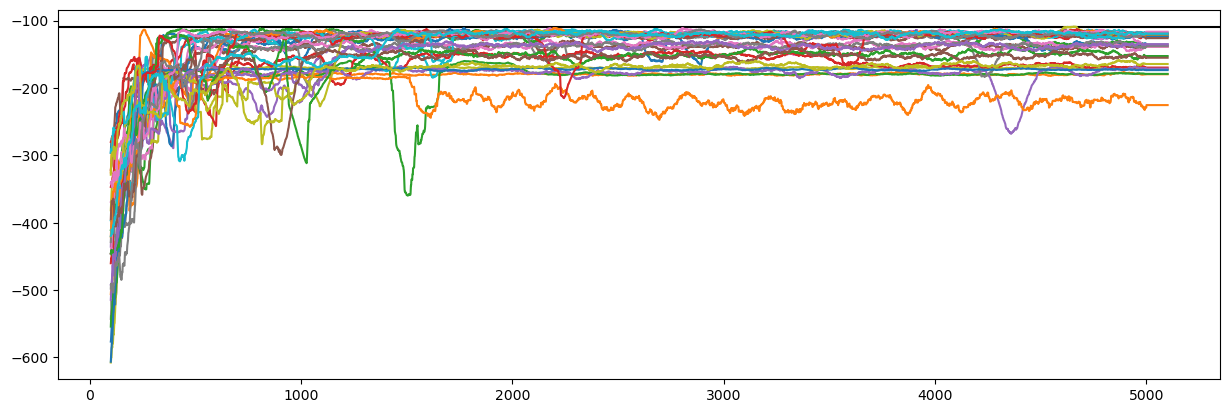

In [18]:
import matplotlib.pyplot as plt
import numpy as np

with open(JSON_RESULTS_FILENAME, "r") as jsonResults:
	results = json.load(jsonResults)

	x = range(NUMBER_OF_EXPLORE_TRIALS, NUMBER_OF_EXPLOIT_TRIALS+NUMBER_OF_EXPLORE_TRIALS+1)

	plt.figure().set_figwidth(15)
	plt.axhline(y = -110.0, color = 'black', linestyle = '-')

	average_scores = []
	for run in results:
		average_scores.append(run["average_scores"])
		plt.plot(x, run["average_scores"])
	data_average_scores = np.array(average_scores)
	data_average_scores = np.average(data_average_scores, axis=0)
	plt.show()

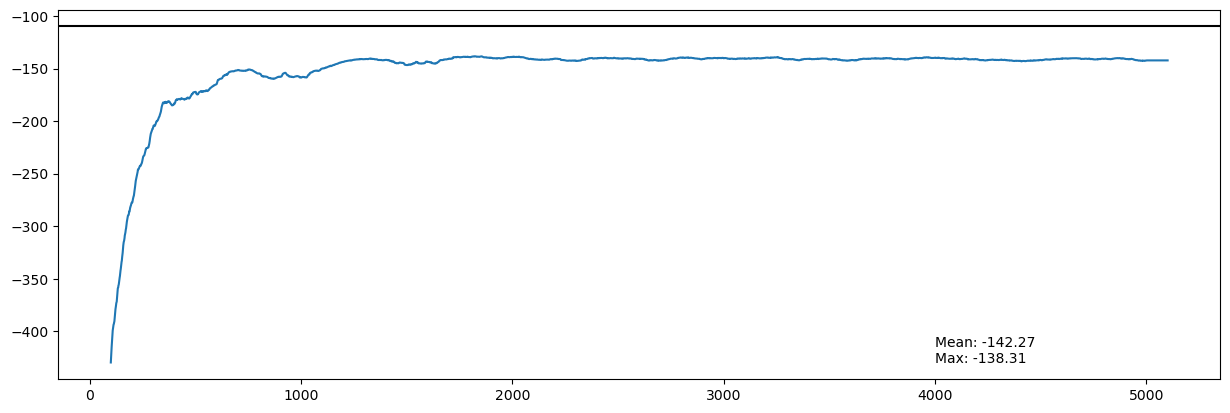

In [24]:
plt.figure().set_figwidth(15)
plt.axhline(y = -110.0, color = 'black', linestyle = '-')
plt.plot(x, data_average_scores)
plt.text(NUMBER_OF_EXPLOIT_TRIALS*4/5, min(data_average_scores), f"Mean: {sum(data_average_scores[-100:]) / len(data_average_scores[-100:]): .2f}\nMax: {max(data_average_scores): .2f}")
plt.show()